### Hypothesis testing for Amazon Book Review Data

#### This dataset is taken from http://jmcauley.ucsd.edu/data/amazon/

<li> Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015


<li> Inferring networks of substitutable and complementary products
J. McAuley, R. Pandey, J. Leskovec
Knowledge Discovery and Data Mining, 2015

This is the book review 5-core data which means that each user and item has 5 reviews each. This is an analysis for a small subset (20,000 rows).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms
%matplotlib inline

In [2]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i > 20000:
            break
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Books_5.json.gz')

In [3]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",1355616000,Spiritually and mentally inspiring! A book tha...,5.0,"12 16, 2012",Wonderful!


In the exploratory analysis of 'Amazon book review' data we found that most of the time high ratings are associated with less helpfullness rating. The goal here is to quantify the statistical significance of that hypothesis. The first element in the helpful column is the number of 'yes' vote and the second element represents the total vote. We are going to create a percentage rating column based on (yes/total). [Note that 90/100 will have the same percentage rating as 9/10 but I am not taking the weighted average]

In [4]:
df1 = df[['helpful', 'overall']]
df1.head(1)

,helpful,overall
0,"[0, 0]",5.0


In [5]:
df1[['helpfulVote', 'totalVote']] = df1['helpful'].apply(pd.Series)
df2 = df1.drop('helpful', axis = 1)
df2.head(2)

C:\Users\Bis\Anaconda2\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,overall,helpfulVote,totalVote
0,5.0,0,0
1,5.0,0,2


In [6]:
df2['percHelpful'] = df2.helpfulVote/df2.totalVote
df2['percHelpful'] = df2['percHelpful'].fillna(0)
df2.head(1)

,overall,helpfulVote,totalVote,percHelpful
0,5.0,0,0,0.0


In [7]:
df2 = df2[df2.percHelpful <= 1.00]

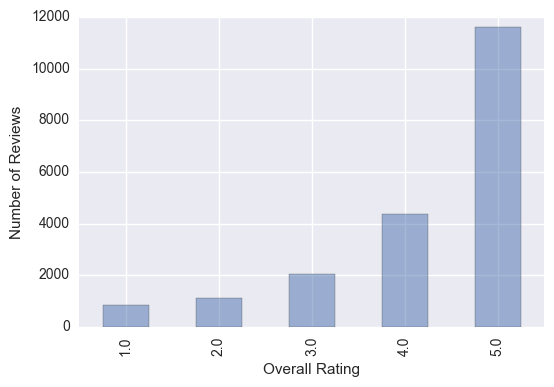

In [8]:
df.groupby('overall').size().plot(kind = 'bar', alpha = 0.5)
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')

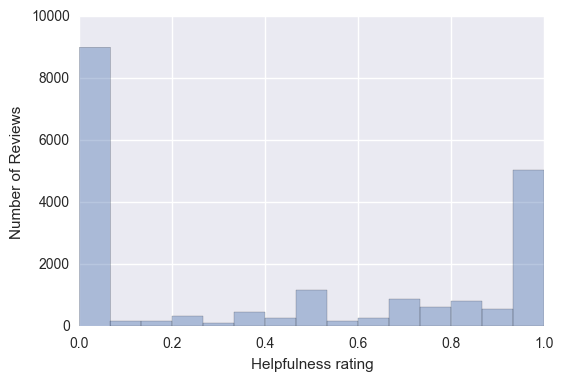

In [9]:
plt.figure(figsize=[6, 4])
sns.distplot(df2.percHelpful, kde = False)
plt.xlabel('Helpfulness rating')
plt.ylabel('Number of Reviews')

Anything below overall rating of 3.0 can be regarded as negative (dislike). We can split the overall rating to positives and negatives (like or dislike).

In [10]:
def partition(x):
    if x < 3.0:
        return 'negative'
    return 'positive'

Score = df2['overall']
Score = Score.map(partition)
tmp = df2
tmp['overall'] = tmp['overall'].map(partition)
tmp.head(1)

,overall,helpfulVote,totalVote,percHelpful
0,positive,0,0,0.0


Helpfulness rating can also be divdied by yes or no. Here, I have taken anything below 50% as 'no'. 

In [11]:
def partitionP(x):
    if x < 0.5:
        return 0.0
    return 1.0

Score = df2['percHelpful']
Score = Score.map(partitionP)
tmp = df2
tmp['percHelpful'] = tmp['percHelpful'].map(partitionP)
tmp.head(1)

,overall,helpfulVote,totalVote,percHelpful
0,positive,0,0,0.0


In [12]:
tmp[tmp.percHelpful == 1.0][:5]

,overall,helpfulVote,totalVote,percHelpful
4,positive,7,9,1.0
14,positive,1,1,1.0
15,positive,1,1,1.0
17,positive,3,5,1.0
18,positive,1,1,1.0


In [13]:
tmp = tmp.drop(['helpfulVote', 'totalVote'], axis = 1)
tmp.head(1)

,overall,percHelpful
0,positive,0.0


After some data manipulation the dataframe has positive/negative & yes/no combination.

In [14]:
tmp[tmp.overall == 'positive'][:5]

,overall,percHelpful
0,positive,0.0
1,positive,0.0
2,positive,0.0
3,positive,0.0
4,positive,1.0


In [15]:
tmp[tmp.overall == 'negative'][:5]

,overall,percHelpful
23,negative,0.0
70,negative,1.0
76,negative,0.0
80,negative,0.0
121,negative,0.0


Number of positive and negative reviews:

In [16]:
len(tmp[tmp.overall =='positive']), len(tmp[tmp.overall =='negative'])

(18014, 1986)

Number of positive reviewers who got a 'yes' rating

In [17]:
sum(tmp[tmp.overall=='positive'].percHelpful)

8341.0

Number of negative reviewers who got a 'yes' rating:

In [18]:
sum(tmp[tmp.overall =='negative'].percHelpful)

1164.0

percentage of positive reviewer with yes rating:

In [19]:
posYes = 8341.0/18014.0
posYes

0.46302875541245697

percentage of neg reviewer with yes rating:

In [20]:
negYes = 1164.0/1986.0
negYes

0.5861027190332326

In [21]:
negYes - posYes

0.12307396362077566

For this sample, we see that negative reviewers got a better helpfulness rating by 12%. We will test the statistical significance of this statement. 

<p> Null hypothesis is that there is no difference, i.e., posYes = negYes.
np and nqs are greater than 10, but **ARE THE REVIEWS INDEPENDENT OF EACH OTHER??** CAN I APPLY CLT?

Using CLT we can calculate z-score, p-values and confidence intervals:

In [22]:
def ZscoreProp(num1, num2, size1, size2):
    num1, num2, size1, size2 = float(num1), float(num2), float(size1), float(size2)
    prop1 = num1/size1
    prop2 = num2/size2
    teststat = abs(prop1 - prop2)
    p_exp = (num1 + num2)/(size1+size2)
    std_err = round(np.sqrt(p_exp*(1-p_exp)*(1/size1 + 1/size2)), 2)
    z_score = round(teststat/std_err, 2)
    p_value = st.norm.sf(z_score)*2
    conf1 = round(teststat - (1.96*std_err), 3)
    conf2 = round(teststat + (1.96*std_err), 3)
    return z_score, p_value, conf1, conf2
ZscoreProp(8341, 1164, 18014, 1986)

(12.31, 8.0023188646810894e-35, 0.103, 0.143)

with a p-value < .001, we can say that negative reviewers are likely to get more helpfulness ratings 95% of the time in the 11.9-12.1% range. 

we can also use statsmodels stats:

In [23]:
from statsmodels.stats import proportion
sms.proportions_ztest(np.array([8341, 1164.0]),np.array([18014, 1986]),value=0.12)

(-20.586421464267627, 3.6322616227125817e-94)

this z-score is different but here again p-value < 0.001. 